In [1]:
from google.colab import drive
drive.mount('/content/drive', timeout_ms=128000000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install openai anthropic pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 4.5 MB/s eta 0:00:00


In [3]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anthropic
from openai import OpenAI
from datetime import datetime
import json

# Experiment configuration parameters
NUM_EXPERIMENTS = 2           # Total number of experiment runs (each run tests all configurations on all baseline ideas)
MAX_ITERATIONS = 6            # Maximum iterations per experiment (1 baseline + up to MAX_ITERATIONS-1 improvements)
MAX_IMPROVEMENTS = MAX_ITERATIONS - 1
TEMPERATURE = 1.0             # Temperature for model calls
MAX_TOKENS = 5000             # Maximum tokens for idea generation/improvement
EVAL_MAX_TOKENS = 5000        # Maximum tokens for evaluation

In [4]:
# Setup Anthropic client
anthropic_client = anthropic.Anthropic(
    api_key="api-key",
)

# Setup OpenAI client
openai_client = OpenAI(
    api_key="api-key",
)

In [5]:
manual_ideas = [
    "From efficiency and speed toward effectiveness and calm\nWhile efficiency (doing things right, according to management guru Peter Drucker) is attractive, the long-term value of GenAI for leaders will be effectiveness (doing the right things). Meaningful outcomes will be more important than streamlined processes—although it may be possible to do both. Leaders will need to discern which efficiency tools contribute to effectiveness as well. Leaders will need to resist the temptation of taking shortcuts that sacrifice long-term effectiveness for short-term gains. The early applications of GenAI have focused on efficiency and getting work done more quickly: make things work faster with fewer mistakes. Offload the busywork that humans don't want to do. Replace humans when possible. Doing the same things faster is just the beginning. Over the next decade, machine/human teams will figure out ways to do better things better.",

    "Before the advent of digital photography, capturing images was a laborious, expensive process. Film was costly, each shot precious. Fixing mistakes in post-production was time-consuming, if possible at all. Early digital cameras, while inferior in quality to their analog counterparts, offered one game-changing advantage: instant feedback. Photographers could immediately see if they got the shot, enabling faster iteration and experimentation. Suddenly, each individual frame mattered less. Shooters could afford to waste exposures chasing spontaneity and serendipity in ways unthinkable to all but the wealthiest artists in the film era.\n\nAs digital cameras evolved and photo editing software like Photoshop emerged, so too did the workflow. No longer did photographers carefully compose a handful of shots to be developed later. They'd rattle off hundreds or thousands of frames, then winnow the collection down to a choice batch. From there, they'd tweak and tune - adjusting lighting, removing blemishes, swapping backgrounds. Even before Photoshop, darkroom techniques allowed manipulating the final image. Rarely would a professional simply use an unedited photo straight from the camera.\n\nThe rise of digital photography upended the traditional economics of the industry. In the analog era, photographers could charge a premium for their expertise and the scarcity of their product. Developing and printing photographs was a time-consuming and expensive process, which meant that clients were often willing to pay handsomely for a professional's services.\n\nAs digital cameras became more ubiquitous and post-production tools more accessible, that scarcity diminished. Suddenly, anyone with a decent eye and a modicum of technical skill could produce high-quality images. This led to a proliferation of amateur and semi-professional photographers, many of whom were willing to work for a fraction of what established pros charged.\n\nWriting is on the cusp of an analogous transformation. For most of history, crafting prose has been painstaking, the process of translating an idea to the page gradual and meticulous. While the cost of writing and printing has declined over time, it remains a slow, deliberate act. Professional writers know the first draft is never the last. Like photographers, they revise, rework, and edit, but the process is time and labor intensive. Clients commissioning written work are lucky to get two or three variations, let alone dozens or hundreds.\n\nAdvances in natural language processing and generation, embodied in large language models, are poised to upend the craft of writing in ways both profound and unpredictable. The ability to conjure up multiple drafts with a few keystrokes, each with a different style, tone, or perspective, will fundamentally alter the way writers work. Iterating on a piece will become more like refining a photograph in Lightroom or Photoshop, a process of progressive refinement rather than linear composition. Initial written outputs will be merely a starting point, a seed to be iterated upon. Writers will generate myriad versions, tweaking tone, swapping characters, and adjusting style as easily as applying an Instagram filter. Some may start with a single draft and branch out, others with many and narrow down. The \"authenticity\" of the process will matter as much as whether a photographer shot on film or digital. The analog look may retain its appeal as an artistic choice, but will be just one option among many.",

    "Outputs from AI systems represent our own Library of Babel, and therefore a new challenge of scale and comprehension. The near-infinite amounts of data we will create with generative AI may never be consumed or even acknowledged by human consciousness. I do wonder what the point of information is if no one is going to actually look at it.\n\nSo, just like with Borges’s Library, we are now confronted with the task of navigating and making sense of this sea of information: figuring out what is accurate or inaccurate, what is useful, what is boring and not worth our time, and of course, what is malicious. The thing is, this isn’t just about fighting misinformation — disinforming or misinforming each other is something that happens in any information-sharing environment, and is therefore a problem that existed before both AI and the internet. The over-arching challenge here is going to be creating a system that doesn’t drown us in useless or erroneous information.\n\nEven if all information produced by LLMs was accurate, our systems are not designed to synthesise that much information or coherent text. We, as a culture, are ill-equipped to accommodate this shift. Look at it this way: before, even though no one human could interact with all information, all information was at least created by humans. That means, at some point, every piece of information out there had some how been ‘touched’ by at least one person. This is important, because a world of human-created information — as opposed to machine-generated information — ensured a baseline expense for producing knowledge.",

    "Content distribution as it stands right now is not beneficial to artists. Our energy should not be wasted trying to maintain these systems — we should be thinking about how to build new ones. We need to envision AI-first distribution platforms (or whatever comes after ‘platforms’) that actually value artists’ work; not because we should swallow whole what AI companies are feeding us, but because AI is absolutely going to change the way we value creative work. Not only is it impossible to keep things how they are — we wouldn’t even want it. Pay-per-mention (or similar approaches) will only shove demonstrably ineffective present-day strategies into emerging technologies."
]

In [6]:
def extract_text_from_content(content):
    """
    Extract text from response content, whether it's a string or a structured object.
    """
    if isinstance(content, str):
        return content
    elif isinstance(content, list):
        extracted_text = ""
        for block in content:
            if hasattr(block, 'text'):
                extracted_text += block.text
            elif isinstance(block, dict) and 'text' in block:
                extracted_text += block['text']
            elif isinstance(block, str):
                extracted_text += block
            else:
                extracted_text += str(block)
        return extracted_text
    else:
        return str(content)

In [7]:
def evaluate_idea_with_claude(idea, temperature=TEMPERATURE, max_tokens=EVAL_MAX_TOKENS):
    """
    Evaluate if an idea is entirely unique using Claude.
    Returns:
        tuple: (evaluation_text, is_novel) where is_novel is a boolean.
    """
    prompt = """
Is this idea entirely unique?
1. Explain why or why not.
2. If it is entirely unique, end your explanation with <true>.
If it is not entirely unique, end your explanation with <false>.
"""
    message = anthropic_client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=max_tokens,
        temperature=temperature,
        messages=[{"role": "user", "content": f"{idea}\n\n{prompt}"}]
    )
    response_text = extract_text_from_content(message.content)
    is_novel = '<true>' in response_text
    print(response_text)
    return response_text, is_novel

def evaluate_idea_with_gpt(idea, temperature=TEMPERATURE, max_tokens=EVAL_MAX_TOKENS):
    """
    Evaluate if an idea is entirely unique using GPT.
    Returns:
        tuple: (evaluation_text, is_novel) where is_novel is a boolean.
    """
    prompt = """
Is this idea entirely unique?
1. Explain why or why not.
2. If it is entirely unique, end your explanation with <true>.
If it is not entirely unique, end your explanation with <false>.
"""
    response = openai_client.chat.completions.create(
        model="gpt-4.5-preview-2025-02-27",
        messages=[{"role": "user", "content": f"{idea}\n\n{prompt}"}],
        response_format={"type": "text"},
        temperature=temperature,
        max_completion_tokens=max_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    response_text = response.choices[0].message.content
    print(response_text)
    is_novel = '<true>' in response_text
    return response_text, is_novel

In [8]:
def improve_idea_with_claude(idea, temperature=TEMPERATURE, max_tokens=MAX_TOKENS):
    """Improve an idea using Claude."""
    message = anthropic_client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=max_tokens,
        temperature=temperature,
        messages=[{"role": "user", "content": f"Rewrite this idea to make it more unique: {idea}"}]
    )
    improved_idea = extract_text_from_content(message.content)
    print(improved_idea)
    return improved_idea

def improve_idea_with_gpt(idea, temperature=TEMPERATURE, max_tokens=MAX_TOKENS):
    """Improve an idea using GPT."""
    response = openai_client.chat.completions.create(
        model="gpt-4.5-preview-2025-02-27",
        messages=[{"role": "user", "content": f"Rewrite this idea to make it more unique: {idea}"}],
        response_format={"type": "text"},
        temperature=temperature,
        max_completion_tokens=max_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    improved_idea = response.choices[0].message.content
    print(improved_idea)
    return improved_idea

In [9]:
def run_experiment_iterations(writer_model, judge_model, baseline_idea, temperature=TEMPERATURE, idea_max_tokens=MAX_TOKENS, eval_max_tokens=EVAL_MAX_TOKENS):
    """
    Run one experiment iteration for a single baseline idea using the specified writer and judge models.
    Returns a dictionary of results including all idea iterations and evaluations.
    """
    baseline_iteration = 0
    improvement_count = 0
    all_ideas = []
    all_evaluations = []
    is_accepted = False
    error_occurred = False
    error_message = None

    # Model details for recording
    model_info = {
        'claude': {'name': 'Claude 3.7 Sonnet', 'version': 'claude-3-7-sonnet-20250219'},
        'gpt': {'name': 'GPT-4.5', 'version': 'gpt-4.5-preview-2025-02-27'}
    }
    writer_details = model_info[writer_model]
    judge_details = model_info[judge_model]

    try:
        # Use the provided baseline idea (iteration 0)
        print(f"Using provided baseline idea:\n{baseline_idea}\n")
        current_idea = baseline_idea
        all_ideas.append({
            "iteration": baseline_iteration,
            "type": "baseline",
            "idea": current_idea,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        })

        # Evaluate the baseline idea
        print(f"Evaluating baseline idea with {judge_model.upper()} judge...")
        if judge_model == 'claude':
            evaluation, is_accepted = evaluate_idea_with_claude(current_idea, temperature, eval_max_tokens)
        else:
            evaluation, is_accepted = evaluate_idea_with_gpt(current_idea, temperature, eval_max_tokens)

        all_evaluations.append({
            "iteration": baseline_iteration,
            "type": "baseline",
            "evaluation": evaluation,
            "is_accepted": is_accepted,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        })
        print(f"Baseline idea {'ACCEPTED' if is_accepted else 'REJECTED'}.\n")

        # If baseline is not accepted, try improvements
        while (not is_accepted) and (improvement_count < MAX_IMPROVEMENTS):
            improvement_count += 1
            current_iteration = baseline_iteration + improvement_count
            print(f"Improvement {improvement_count}/{MAX_IMPROVEMENTS}: Improving idea with {writer_model.upper()} writer...")
            if writer_model == 'claude':
                current_idea = improve_idea_with_claude(current_idea, temperature, idea_max_tokens)
            else:
                current_idea = improve_idea_with_gpt(current_idea, temperature, idea_max_tokens)

            all_ideas.append({
                "iteration": current_iteration,
                "type": "improvement",
                "improvement_number": improvement_count,
                "idea": current_idea,
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            })

            print(f"Evaluating improvement {improvement_count} with {judge_model.upper()} judge...")
            if judge_model == 'claude':
                evaluation, is_accepted = evaluate_idea_with_claude(current_idea, temperature, eval_max_tokens)
            else:
                evaluation, is_accepted = evaluate_idea_with_gpt(current_idea, temperature, eval_max_tokens)

            all_evaluations.append({
                "iteration": current_iteration,
                "type": "improvement",
                "improvement_number": improvement_count,
                "evaluation": evaluation,
                "is_accepted": is_accepted,
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            })
            print(f"Improvement {improvement_count} result: {'ACCEPTED' if is_accepted else 'REJECTED'}.\n")
            if is_accepted:
                break

        if not is_accepted:
            print(f"Reached maximum improvements without acceptance.\n")

        result = {
            "writer_model": writer_model,
            "judge_model": judge_model,
            "writer_details": writer_details,
            "judge_details": judge_details,
            "temperature": temperature,
            "idea_max_tokens": idea_max_tokens,
            "eval_max_tokens": eval_max_tokens,
            "improvements_to_acceptance": improvement_count if is_accepted else -1,
            "total_iterations": improvement_count + 1,
            "was_accepted": is_accepted,
            "baseline_was_accepted": is_accepted and improvement_count == 0,
            "all_ideas": all_ideas,
            "all_evaluations": all_evaluations,
            "error_occurred": error_occurred,
            "error_message": error_message,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        return result

    except Exception as e:
        error_message = str(e)
        error_occurred = True
        print(f"Error during experiment iteration: {error_message}")
        return {
            "writer_model": writer_model,
            "judge_model": judge_model,
            "writer_details": writer_details,
            "judge_details": judge_details,
            "temperature": temperature,
            "idea_max_tokens": idea_max_tokens,
            "eval_max_tokens": eval_max_tokens,
            "improvements_to_acceptance": -1,
            "total_iterations": improvement_count + 1,
            "was_accepted": False,
            "baseline_was_accepted": False,
            "all_ideas": all_ideas,
            "all_evaluations": all_evaluations,
            "error_occurred": error_occurred,
            "error_message": error_message,
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

In [10]:
def run_all_experiments(num_experiments=NUM_EXPERIMENTS, temperature=TEMPERATURE, idea_max_tokens=MAX_TOKENS, eval_max_tokens=EVAL_MAX_TOKENS):
    """
    Run the entire experiment num_experiments times.
    For each experiment run, all baseline ideas are processed under every writer/judge configuration.
    Returns:
        list: A list of all experiment results.
    """
    all_results = []
    configurations = [
        ("claude", "gpt"),    # Claude as writer, GPT as judge
        ("gpt", "claude"),    # GPT as writer, Claude as judge
        ("claude", "claude"), # Claude as writer, Claude as judge
        ("gpt", "gpt")        # GPT as writer, GPT as judge
    ]

    for exp_run in range(num_experiments):
        print(f"\nStarting Experiment Run {exp_run+1}/{num_experiments}...")
        for writer, judge in configurations:
            print(f"\nConfiguration: {writer.upper()} as writer, {judge.upper()} as judge")
            for idea in manual_ideas:
                print(f"\nProcessing baseline idea:\n\"{idea}\"\n")
                # Small delay to avoid rate limiting (if needed)
                time.sleep(3)
                result = run_experiment_iterations(
                    writer_model=writer,
                    judge_model=judge,
                    baseline_idea=idea,
                    temperature=temperature,
                    idea_max_tokens=idea_max_tokens,
                    eval_max_tokens=eval_max_tokens
                )
                all_results.append(result)
    return all_results

In [11]:
def create_results_dataframe(all_results):
    """
    Convert experiment results into pandas DataFrames for analysis.
    Returns:
        tuple: (df_main, df_ideas, df_evaluations, df_all)
    """
    main_data = []
    idea_rows = []
    eval_rows = []

    # Collect experiment-level configuration and details.
    for idx, result in enumerate(all_results):
        experiment_record = {
            "experiment_id": idx,
            "writer_model": result.get("writer_model", "unknown"),
            "judge_model": result.get("judge_model", "unknown"),
            "writer_name": result.get("writer_details", {}).get("name", "unknown"),
            "judge_name": result.get("judge_details", {}).get("name", "unknown"),
            "writer_version": result.get("writer_details", {}).get("version", "unknown"),
            "judge_version": result.get("judge_details", {}).get("version", "unknown"),
            "temperature": result.get("temperature", TEMPERATURE),
            "idea_max_tokens": result.get("idea_max_tokens", MAX_TOKENS),
            "eval_max_tokens": result.get("eval_max_tokens", EVAL_MAX_TOKENS),
            "improvements_to_acceptance": result.get("improvements_to_acceptance", -1),
            "total_iterations": result.get("total_iterations", 0),
            "was_accepted": result.get("was_accepted", False),
            "baseline_was_accepted": result.get("baseline_was_accepted", False),
            "error_occurred": result.get("error_occurred", False),
            "error_message": result.get("error_message", ""),
            "timestamp": result.get("timestamp", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        }
        main_data.append(experiment_record)

        # Record iteration-level idea texts.
        if "all_ideas" in result:
            for idea_data in result["all_ideas"]:
                idea_rows.append({
                    "experiment_id": idx,
                    "iteration": idea_data.get("iteration", -1),
                    "type": idea_data.get("type", "unknown"),
                    "improvement_number": idea_data.get("improvement_number", 0),
                    "idea_text": idea_data.get("idea", ""),
                    "timestamp": idea_data.get("timestamp", "")
                })
        # Record iteration-level evaluation details.
        if "all_evaluations" in result:
            for eval_data in result["all_evaluations"]:
                eval_rows.append({
                    "experiment_id": idx,
                    "iteration": eval_data.get("iteration", -1),
                    "type": eval_data.get("type", "unknown"),
                    "improvement_number": eval_data.get("improvement_number", 0),
                    "evaluation_text": eval_data.get("evaluation", ""),
                    "is_accepted": eval_data.get("is_accepted", False),
                    "timestamp": eval_data.get("timestamp", "")
                })

    df_main = pd.DataFrame(main_data)
    df_ideas = pd.DataFrame(idea_rows)
    df_evaluations = pd.DataFrame(eval_rows)

    # Create a flattened DataFrame (df_all) that merges experiment-level config with each iteration’s data.
    all_data_rows = []
    for exp_id in df_main['experiment_id'].unique():
        # Get experiment configuration details.
        experiment_config = df_main[df_main['experiment_id'] == exp_id].iloc[0].to_dict()
        ideas_exp = df_ideas[df_ideas['experiment_id'] == exp_id]
        evals_exp = df_evaluations[df_evaluations['experiment_id'] == exp_id]
        max_iter = max(
            ideas_exp['iteration'].max() if not ideas_exp.empty else -1,
            evals_exp['iteration'].max() if not evals_exp.empty else -1
        )
        for iter_num in range(max_iter + 1):
            idea_text = ideas_exp[ideas_exp['iteration'] == iter_num]['idea_text'].values
            eval_text = evals_exp[evals_exp['iteration'] == iter_num]['evaluation_text'].values
            is_accepted = evals_exp[evals_exp['iteration'] == iter_num]['is_accepted'].values
            # Build a row that includes both the iteration details and the experiment-level configuration.
            row = {
                "experiment_id": exp_id,
                "iteration": iter_num,
                "idea_text": idea_text[0] if len(idea_text) > 0 else "",
                "evaluation_text": eval_text[0] if len(eval_text) > 0 else "",
                "is_accepted": is_accepted[0] if len(is_accepted) > 0 else False,
            }
            # Merge in all experiment-level details.
            row.update(experiment_config)
            all_data_rows.append(row)

    df_all = pd.DataFrame(all_data_rows)
    return df_main, df_ideas, df_evaluations, df_all

In [12]:
print("Starting experiments...")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"Experiment run timestamp: {timestamp}")

# Run all experiments (NUM_EXPERIMENTS runs over all configurations and baseline ideas)
all_results = run_all_experiments(
    num_experiments=NUM_EXPERIMENTS,
    temperature=TEMPERATURE,
    idea_max_tokens=MAX_TOKENS,
    eval_max_tokens=EVAL_MAX_TOKENS
)

# Create DataFrames for analysis
df_main, df_ideas, df_evaluations, df_all = create_results_dataframe(all_results)

# Save DataFrames to CSV files
df_main.to_csv(f"/content/drive/MyDrive/Novelty_experiments/uniqueness_evaluation_using_manual_baselines_entirely_unique/novelty_experiments_main_{timestamp}.csv", index=False)
df_ideas.to_csv(f"/content/drive/MyDrive/Novelty_experiments/uniqueness_evaluation_using_manual_baselines_entirely_unique/novelty_experiments_ideas_{timestamp}.csv", index=False)
df_evaluations.to_csv(f"/content/drive/MyDrive/Novelty_experiments/uniqueness_evaluation_using_manual_baselines_entirely_unique/novelty_experiments_evaluations_{timestamp}.csv", index=False)
df_all.to_csv(f"/content/drive/MyDrive/Novelty_experiments/uniqueness_evaluation_using_manual_baselines_entirely_unique/novelty_experiments_all_data_{timestamp}.csv", index=False)

# Save raw results to a JSON file
with open(f"novelty_experiments_raw_{timestamp}.json", 'w') as f:
    json.dump(all_results, f, indent=2, default=str)

print(f"\nResults saved with timestamp: {timestamp}")
print("Files created:")
print(f"  - novelty_experiments_main_{timestamp}.csv")
print(f"  - novelty_experiments_ideas_{timestamp}.csv")
print(f"  - novelty_experiments_evaluations_{timestamp}.csv")
print(f"  - novelty_experiments_all_data_{timestamp}.csv")
print(f"  - novelty_experiments_raw_{timestamp}.json")

Streaming output truncated to the last 5000 lines.

The current generative AI landscape, with its fixation on productivity enhancements and workflow optimizations, merely scratches the surface of what's possible. These initial applications are transitional fossils – evolutionary stepping stones toward a more profound communion between silicon and synapse.

Tomorrow belongs to those who cultivate "creative dissonance" – the deliberate cultivation of productive tension between human and machine thinking. Rather than pursuing seamless integration, vanguard organizations will strategically maintain generative boundaries where the friction between different cognitive architectures sparks unprecedented innovation. The most transformative leaders recognize that too much algorithmic harmony produces cognitive echo chambers, while calibrated cognitive diversity creates revelatory breakthroughs.

We are witnessing the nascent development of "prismatic intelligence" – collaborative systems that r


Basic Analysis:
Total experiments: 32
Failed experiments: 0 (0.0%)
Successful experiments: 32 (100.0%)

Summary by configuration:
  writer_model judge_model  acceptance_rate  baseline_acceptance_rate  \
0       claude      claude              0.0                       0.0   
1       claude         gpt              0.0                       0.0   
2          gpt      claude              0.0                       0.0   
3          gpt         gpt              0.0                       0.0   

   avg_improvements  median_improvements  experiment_count  
0              -1.0                 -1.0                 8  
1              -1.0                 -1.0                 8  
2              -1.0                 -1.0                 8  
3              -1.0                 -1.0                 8  


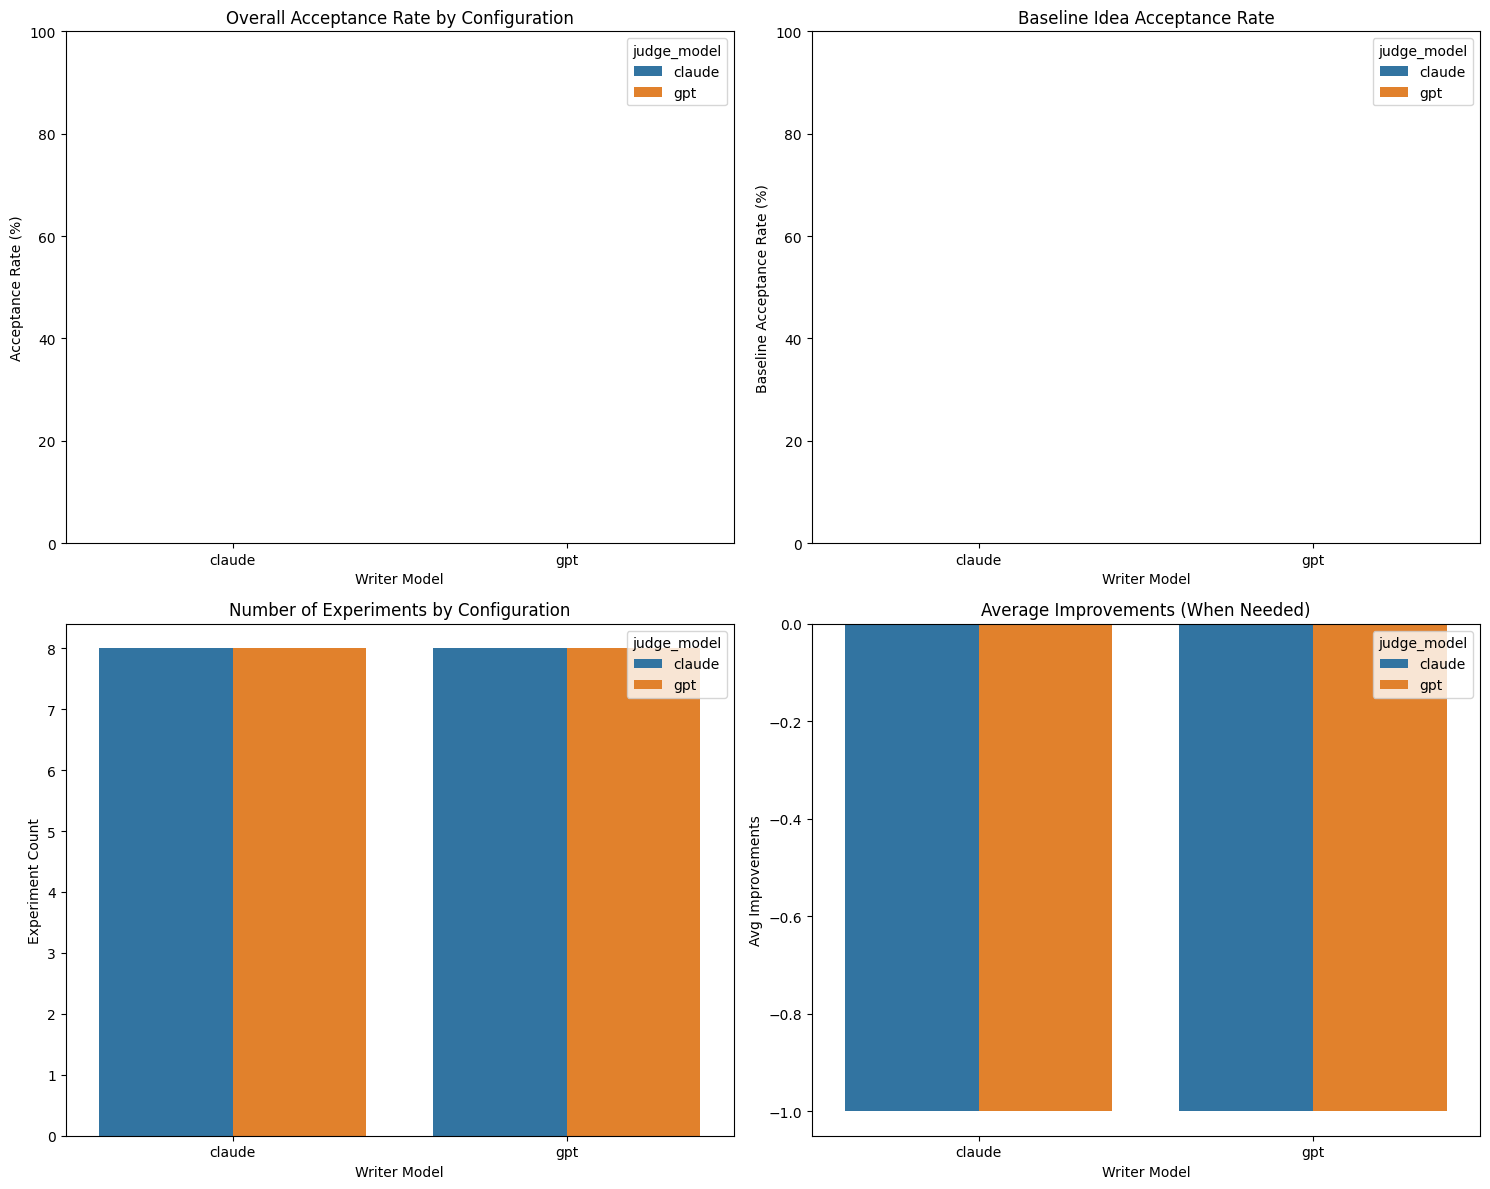

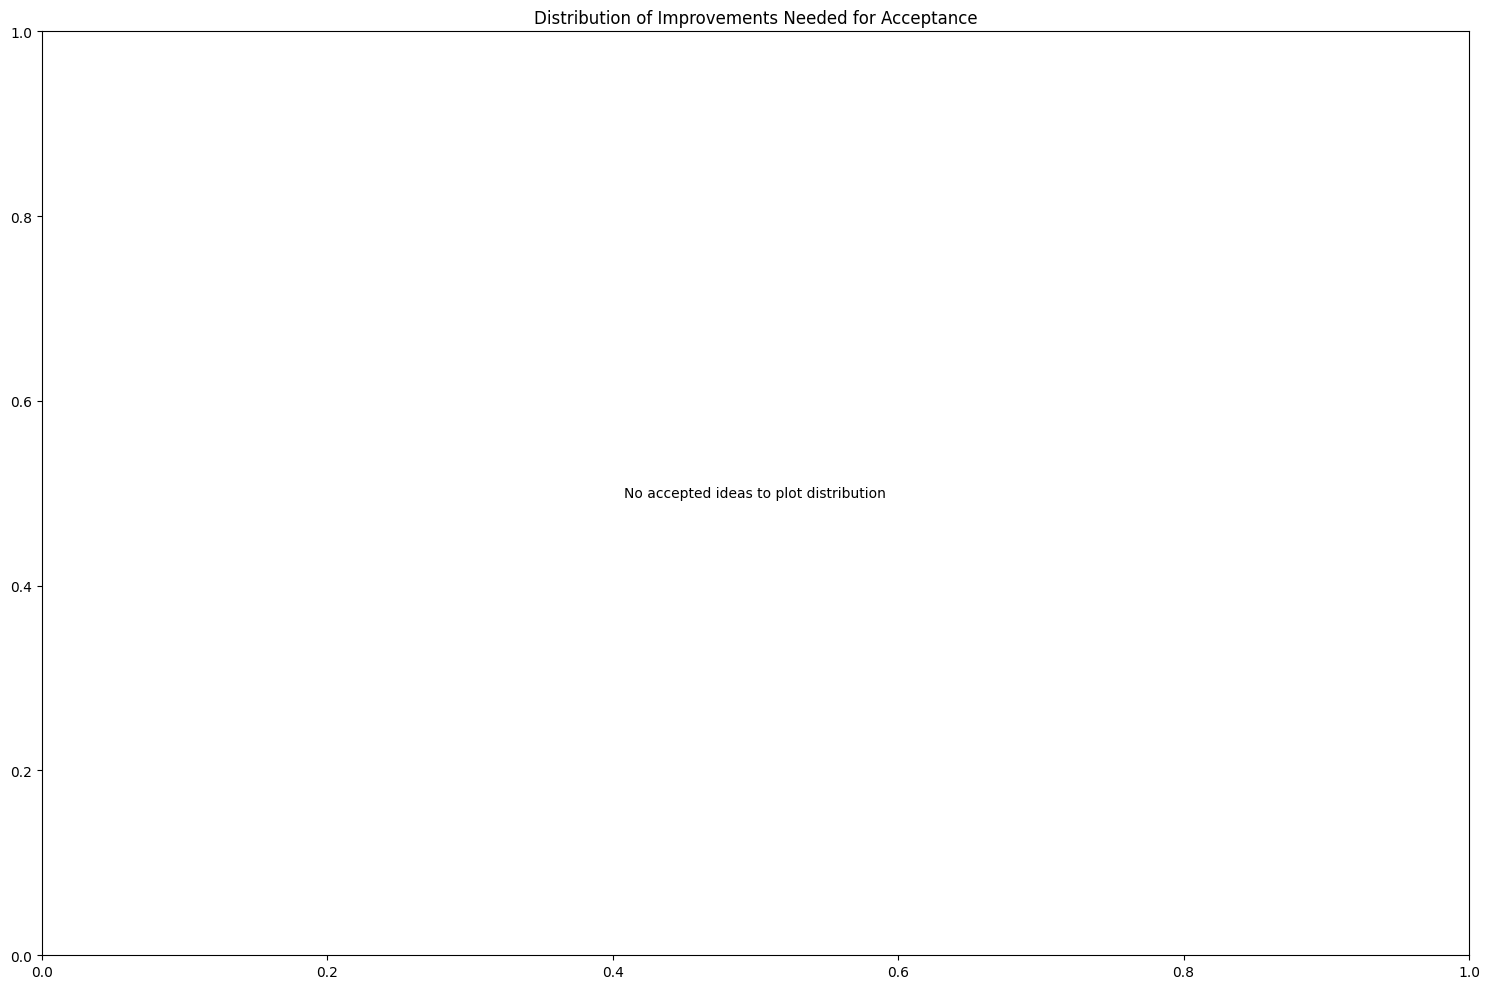

In [13]:
# Basic analysis of the results
failed_experiments = df_main[df_main['error_occurred'] == True]
successful_experiments = df_main[df_main['error_occurred'] == False]

print("\nBasic Analysis:")
print(f"Total experiments: {len(df_main)}")
print(f"Failed experiments: {len(failed_experiments)} ({len(failed_experiments) / len(df_main) * 100:.1f}%)")
print(f"Successful experiments: {len(successful_experiments)} ({len(successful_experiments) / len(df_main) * 100:.1f}%)")

if not successful_experiments.empty:
    print("\nSummary by configuration:")
    summary = successful_experiments.groupby(['writer_model', 'judge_model']).agg({
        'was_accepted': 'mean',
        'baseline_was_accepted': 'mean',
        'improvements_to_acceptance': ['mean', 'median', 'count']
    }).reset_index()
    summary.columns = ['writer_model', 'judge_model', 'acceptance_rate', 'baseline_acceptance_rate',
                       'avg_improvements', 'median_improvements', 'experiment_count']
    summary['acceptance_rate'] *= 100
    summary['baseline_acceptance_rate'] *= 100
    print(summary)

    # Overall Acceptance Rate by Configuration
    plt.figure(figsize=(15, 12))

    plt.subplot(2, 2, 1)
    sns.barplot(x='writer_model', y='acceptance_rate', hue='judge_model', data=summary)
    plt.title('Overall Acceptance Rate by Configuration')
    plt.xlabel('Writer Model')
    plt.ylabel('Acceptance Rate (%)')
    plt.ylim(0, 100)

    plt.subplot(2, 2, 2)
    sns.barplot(x='writer_model', y='baseline_acceptance_rate', hue='judge_model', data=summary)
    plt.title('Baseline Idea Acceptance Rate')
    plt.xlabel('Writer Model')
    plt.ylabel('Baseline Acceptance Rate (%)')
    plt.ylim(0, 100)

    plt.subplot(2, 2, 3)
    sns.barplot(x='writer_model', y='experiment_count', hue='judge_model', data=summary)
    plt.title('Number of Experiments by Configuration')
    plt.xlabel('Writer Model')
    plt.ylabel('Experiment Count')

    plt.subplot(2, 2, 4)
    sns.barplot(x='writer_model', y='avg_improvements', hue='judge_model', data=summary)
    plt.title('Average Improvements (When Needed)')
    plt.xlabel('Writer Model')
    plt.ylabel('Avg Improvements')

    plt.tight_layout()
    plt.savefig(f"novelty_experiments_analysis_{timestamp}.png")
    plt.show()

    # Detailed Plot: Distribution of improvements needed for acceptance
    plt.figure(figsize=(15, 10))
    accepted_df = successful_experiments[successful_experiments['was_accepted'] == True]
    if not accepted_df.empty:
        improvements_dist = accepted_df.groupby(['writer_model', 'judge_model', 'improvements_to_acceptance']).size().reset_index(name='count')
        sns.barplot(data=improvements_dist, x='improvements_to_acceptance', y='count', hue='writer_model')
        plt.title('Distribution of Improvements Needed for Acceptance')
        plt.xlabel('Number of Improvements')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, "No accepted ideas to plot distribution", ha='center', va='center')
        plt.title('Distribution of Improvements Needed for Acceptance')
    plt.tight_layout()
    plt.savefig(f"novelty_experiments_detailed_{timestamp}.png")
    plt.show()
else:
    print("No successful experiments to analyze.")